In [122]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from shapely import Point, LineString, Polygon
import shapely
import random
from enum import Enum
from rasterio.mask import mask
from CPP_Planner import CPP_Planner_Kit

In [123]:
# hard-code 各个列表
swath_sep_indxes = [0, 28, 39, 49, 71]
useful_land_indexes = [0, 4, 5, 6]
# 一些农机数据
vehicle_weight = 1980 + 342.5  # 拖拉机 + 耕作机械 重量（kg）
vehicle_wheel_width = 1440  # 农机轮距（mm）

opti_path = '../PSO_opt_result/opt5/pso_result.csv'
# real_swath_path = '../Scratch/test_Load_Shp/test_shps/swath_group_1.shp'
# straight_swath_path = 'GIS_data/straight_swaths/straight_swaths.shp'
real_swath_path = r'GIS_data/路径规划优化用数据/all_swaths/all_swaths_group.shp'
straight_swath_path = r'GIS_data/路径规划优化用数据/all_swaths/all_straight_swaths_group.shp'
opti_parameters = pd.read_csv(opti_path)
real_swath = gpd.read_file(real_swath_path)
straight_swath = gpd.read_file(straight_swath_path)
all_land = gpd.read_file('../Scratch/test_Load_Shp/shp_file/村地和道路/村地地块区域.shp')
print(opti_parameters.shape)
print('straight and real swaths: ', len(straight_swath), end=' ')
print(len(real_swath))

(100, 6)
straight and real swaths:  71 71


In [124]:
# 提取地形图
with rasterio.open('GIS_data/路径规划优化用数据/2m_pClouds_regen_dem_cm.tif') as dem_src:
    dem_array = dem_src.read(1)
with rasterio.open('GIS_data/路径规划优化用数据/Aspect_clip_pcGen_2m_cm1.tif') as aspect_src:
    aspect_array = aspect_src.read(1)
with rasterio.open('GIS_data/路径规划优化用数据/Slope_clip_pcGen_2m_cm1.tif') as slope_src:
    slope_array = slope_src.read(1)
with rasterio.open('GIS_data/路径规划优化用数据/Curvatu_clip_pcGen_2m_cm1.tif') as curvature_src:
    curvature_array = curvature_src.read(1)
[dem_array.shape, aspect_array.shape, slope_array.shape, curvature_array.shape]

[(507, 440), (507, 440), (507, 440), (507, 440)]

In [125]:
land_ind = 0
single_land = CPP_Planner_Kit.get_single_shp(all_land, useful_land_indexes[land_ind])
# 选取特定的 swaths 进行演示
real_swath = real_swath[swath_sep_indxes[land_ind]: swath_sep_indxes[land_ind + 1]]
straight_swath = straight_swath[swath_sep_indxes[land_ind]: swath_sep_indxes[land_ind + 1]]
print('Now swaths contains: {} swaths'.format(len(real_swath)))

# 计算地块内平均值和最小值
slope_src = rasterio.open('GIS_data/路径规划优化用数据/Slope_clip_pcGen_2m_cm1.tif')
clip_slope_raster, _trans = mask(slope_src, single_land.geometry.values.tolist(), crop=True)
single_slope_mean = np.mean(clip_slope_raster[clip_slope_raster != clip_slope_raster.min()])
single_slope_min = np.min(clip_slope_raster[clip_slope_raster != clip_slope_raster.min()])
[single_slope_mean, single_slope_min]

Now swaths contains: 28 swaths


[7.3337226, 0.36518544]

0.2878694143845874


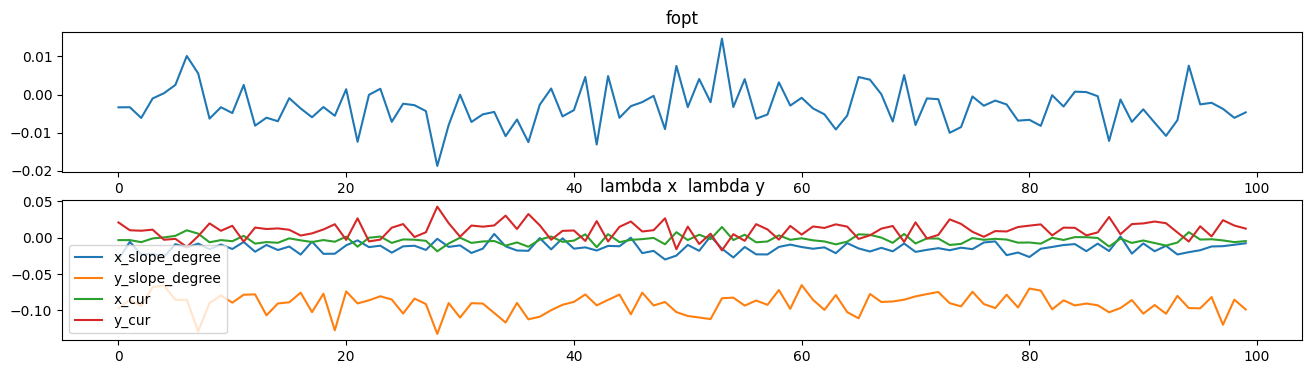

In [126]:
# 显示优化的 fopt
print(opti_parameters['4'].min())
# print(opti_parameters['2'].min())
plt.figure(figsize=(16, 4))
plt.subplot(211)
plt.title('fopt')
opti_parameters['2'].plot()
plt.subplot(212)
# plt.figure(figsize=(16, 4))
plt.title('lambda x  lambda y')
opti_parameters['0'].plot()
opti_parameters['1'].plot()
opti_parameters['2'].plot()
opti_parameters['3'].plot()
plt.legend(['x_slope_degree', 'y_slope_degree', 'x_cur', 'y_cur'])

In [127]:
# 找到最优 foptimal 的索引，取出其 xoff yoff 的参数
optimal_params = opti_parameters.iloc[opti_parameters['4'].idxmin()]
# optimal_params = opti_parameters.iloc[25]
optimal_params[1:]

0   -0.010614
1   -0.109738
2   -0.000039
3    0.001318
4    0.287869
Name: 30, dtype: float64

In [128]:
best_lambda_x, best_lambda_y = optimal_params[1], optimal_params[2]
best_lambda_cur_x, best_lambda_cur_y = optimal_params[3], optimal_params[4]
print(best_lambda_x, best_lambda_y, best_lambda_cur_x, best_lambda_cur_y)
# print(best_lambda_x, best_lambda_y)

-0.0106143750972069 -0.1097379174182606 -3.8869463978369895e-05 0.0013175772240686


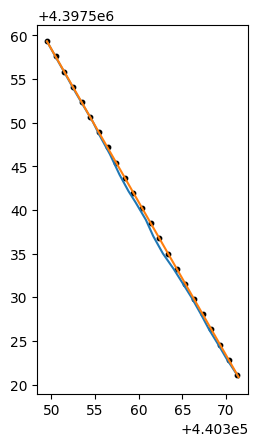

In [129]:
# 随机选择一个点进行采样和模拟
sample_ind = random.randint(0, len(real_swath))
sample_real_land = real_swath.geometry.iloc[sample_ind]
sample_straight_land = straight_swath.geometry.iloc[sample_ind]
# 采样
sample_points = np.arange(0, sample_real_land.length, 2)
sample_points = [sample_straight_land.interpolate(sample_point) for sample_point in sample_points]
# show
_, ax = plt.subplots()
ax.set_aspect('equal')
ax.plot(*sample_real_land.xy)
ax.plot(*sample_straight_land.xy)
for sample_point in sample_points:
    ax.scatter(*sample_point.xy, color='black', s=10)

In [130]:
# 取出当前位置上的地形信息
class raster(Enum):
    DEM = 1
    ASPECT = 2
    SLOPE = 3
    CURVATURE = 4
def get_11_from_raster(point: Point, category):    
    if category == raster.SLOPE:
        temp_raster = slope_array
        temp_src = slope_src
    elif category == raster.ASPECT:
        temp_raster = aspect_array
        temp_src = aspect_src
    elif category == raster.CURVATURE:
        temp_raster = curvature_array
        temp_src = curvature_src
    else:
        temp_raster = dem_array
        temp_src = dem_src
    row, col = temp_src.index(point.x, point.y)
    return temp_raster[row, col]

In [131]:
sample_points_data = []
for sample_point in sample_points:
    new_row = [
        sample_point.x, sample_point.y,
        get_11_from_raster(sample_point, category=raster.DEM),
        get_11_from_raster(sample_point, category=raster.ASPECT),
        # get_11_from_raster(sample_point, category=raster.SLOPE),
        abs(get_11_from_raster(sample_point, category=raster.SLOPE) - single_slope_mean),
        get_11_from_raster(sample_point, category=raster.CURVATURE)
    ]
    sample_points_data.append(new_row)

In [132]:
sample_points_data = np.array(sample_points_data)
# sample_points_data

In [133]:
def model_fit(lambdas, data):
    # print(data, '1')
    aspect = np.deg2rad(data[3])
    origin_x, origin_y, height, slope = data[0], data[1], data[2], data[4]
    curvature = data[5]
    # x_off = lambdas[0] * np.cos(aspect) * slope
    # y_off = lambdas[1] * np.sin(aspect) * slope
    x_off = lambdas[0] * np.cos(aspect) * slope + lambdas[2] * curvature
    y_off = lambdas[1] * np.sin(aspect) * slope + lambdas[3] * curvature
    
    new_x = origin_x + x_off
    new_y = origin_y + y_off
    return Point(new_x, new_y)

In [134]:
simul_points = []
for point in sample_points_data:
    # print(list(point))
    simul_points.append(model_fit(optimal_params[1:], point))
# print(simul_points[:3])
optimal_params[:]

Unnamed: 0    30.000000
0             -0.010614
1             -0.109738
2             -0.000039
3              0.001318
4              0.287869
Name: 30, dtype: float64

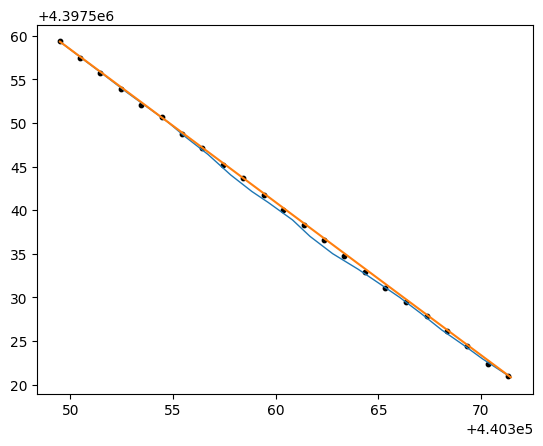

In [135]:
# 检测
simul_line = LineString(simul_points)
_, ax = plt.subplots()
# ax.set_aspect('equal')
# ax.plot(*simul_line.xy)
for point in simul_points:
    ax.scatter(*point.xy, color='black', s=10)
ax.plot(*sample_real_land.xy, linewidth=1)
ax.plot(*sample_straight_land.xy)

simulation begin


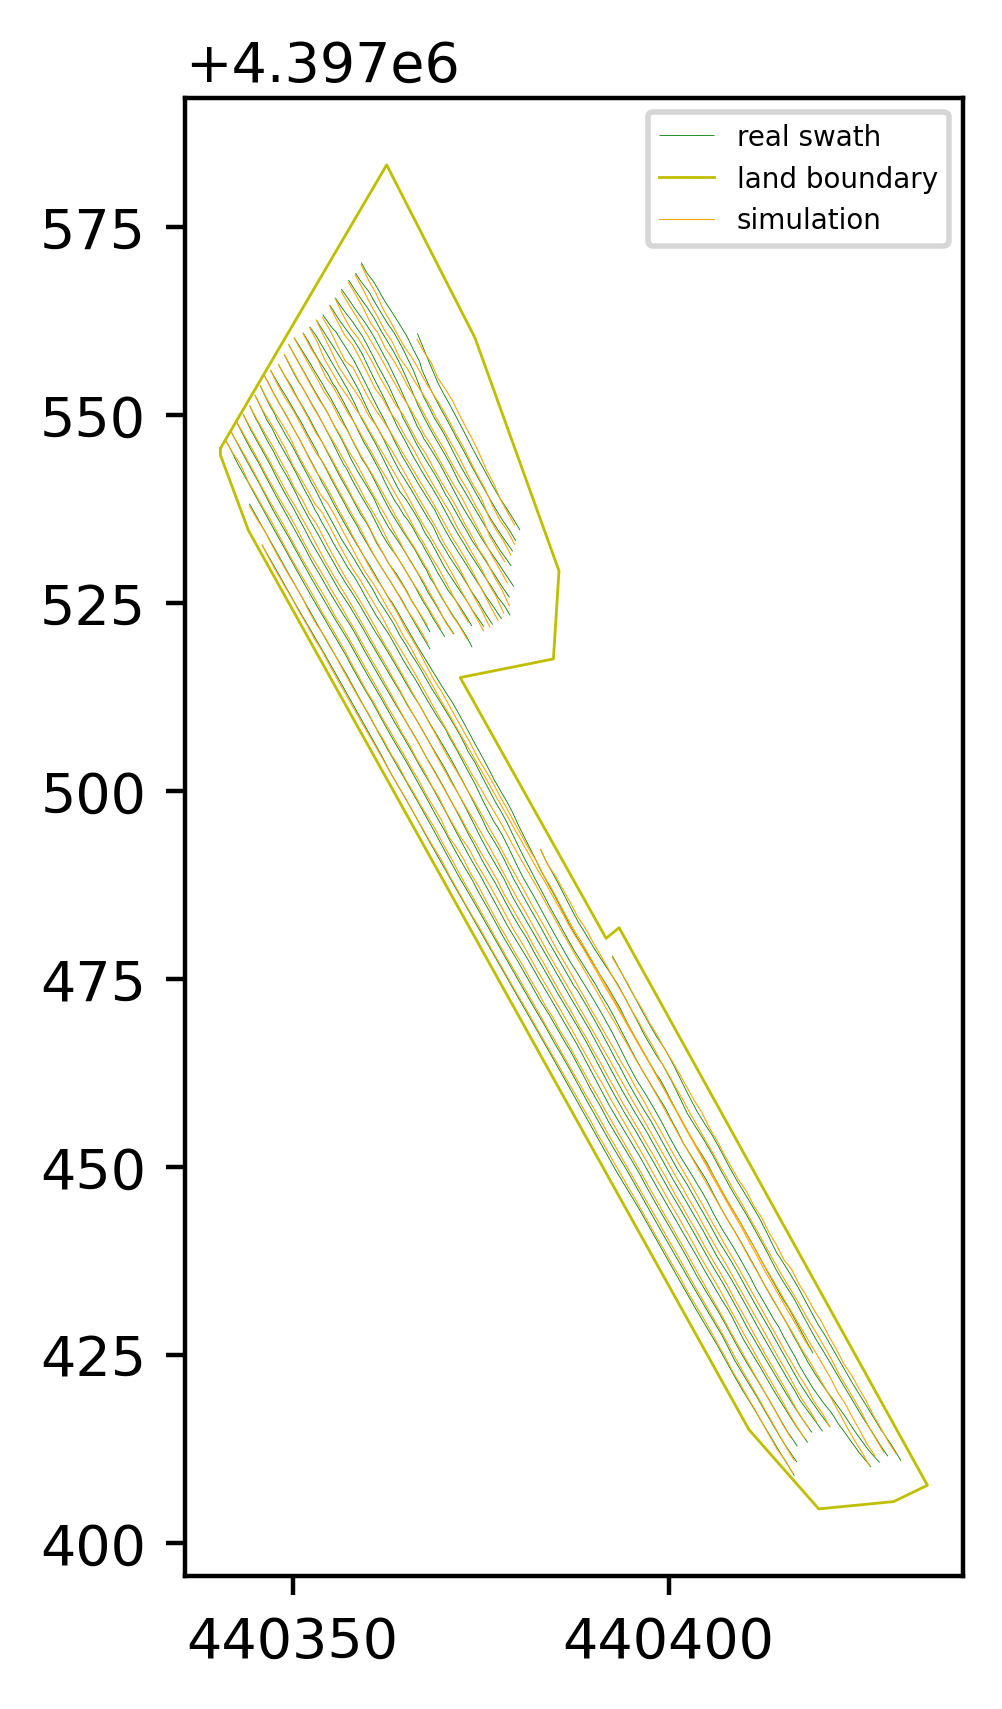

In [141]:
algor_gen_shp_path = r'../gen_paths/gen_01/gen_01.shp'
# algor_gen_shp = gpd.read_file(algor_gen_shp_path)
# straight_swath = algor_gen_shp
# 查看所有的路径
_, ax = plt.subplots(dpi=400)
ax.set_aspect('equal')
sample_accuracy = 2
# straight_swath.plot(ax=ax, color='black', linewidth=0.15)
real_swath.plot(ax=ax, color='g', linewidth=0.15)
ax.plot(*all_land.geometry.iloc[useful_land_indexes[land_ind]].exterior.xy, color='y', linewidth=0.5)

all_distance_data = []
all_simulated_lines = []

print('simulation begin')
for temp_real_line, temp_straight_line in zip(real_swath.geometry, straight_swath.geometry):
    samples = np.arange(0, temp_real_line.length, sample_accuracy)
    temp_result_points = []
    temp_distance_data = []
    for i, sample in enumerate(samples):
        # TODO: 找到问题所在
        temp_sample_point = temp_straight_line.interpolate(sample)
        temp_point_data = [
            temp_sample_point.x, temp_sample_point.y,
            get_11_from_raster(temp_sample_point, raster.DEM),
            get_11_from_raster(temp_sample_point, raster.ASPECT),
            # get_11_from_raster(temp_sample_point, raster.SLOPE),
            abs(get_11_from_raster(temp_sample_point, raster.SLOPE) - single_slope_mean),
            get_11_from_raster(temp_sample_point, raster.CURVATURE)
        ]
        # temp_simu_point = model_fit(optimal_params[1:], temp_point_data)
        temp_simu_point = model_fit(optimal_params[1:], temp_point_data)
        temp_result_points.append(temp_simu_point)
        # 计算距离
        temp_distance_data.append(temp_simu_point.distance(temp_real_line))
    all_distance_data.append(temp_distance_data)
    # print(len(temp_result_points))
    temp_modi_line = LineString(temp_result_points)
    all_simulated_lines.append(temp_modi_line)
    ax.plot(*temp_modi_line.xy, color='orange', linewidth=0.2)
# straight_swath.plot(ax=ax, color='black', linewidth=0.15, linestyle='--')
# plt.legend(['real swath', 'straight swath', 'land boundary', 'simulation'])
plt.legend(['real swath', 'land boundary', 'simulation'], fontsize=5)
# print('saving')
# plt.savefig('swath_simu.png', dpi=1000)
all_simulated_lines = gpd.GeoDataFrame(geometry=all_simulated_lines)

Text(0.5, 1.0, 'Average difference distance (m)')

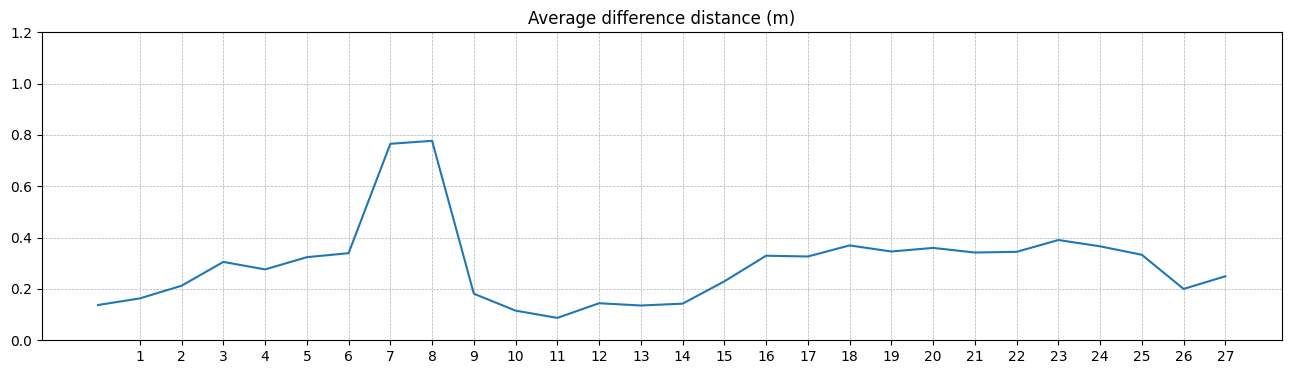

In [137]:
_, ax = plt.subplots(figsize=(16, 4))
all_average_distance = []
for line in all_distance_data:
    all_average_distance.append(np.mean(line))
ax.plot(all_average_distance)
ax.grid(linestyle='--', linewidth=0.5)
plt.xticks(np.arange(1, len(real_swath), 1))
plt.ylim((0, 1.2))
plt.title("Average difference distance (m)")

0.3228395159065531


Text(0.5, 1.0, 'all point difference distance (m)')

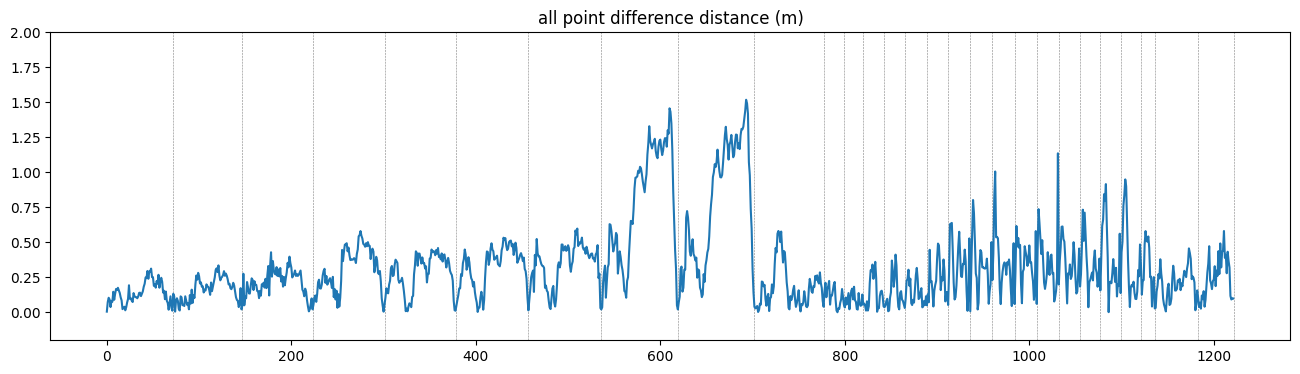

In [138]:
flatten_distances = []
flatten_gap = []
# 控制 plt 的长宽比为 4: 1
plt.figure(figsize=(16, 4))
for i in all_distance_data:
    flatten_distances += i
    flatten_gap.append(len(i))
flatten_distances = np.array(flatten_distances)
# flatten_distances[flatten_distances >= 1] = 0
print(np.mean(flatten_distances))
plt.vlines(np.cumsum(flatten_gap), ymin=-0.2, ymax=2.5, colors="gray", linestyles="dashed", linewidth=0.4)
plt.ylim((-0.2, 2))
plt.plot(flatten_distances)
# 在固定的 x 位置上显示竖直的虚线
plt.title("all point difference distance (m)")

In [139]:
df_flatten_distances = pd.DataFrame(flatten_distances)
df_flatten_distances.describe()

,0
count,1222.000000
mean,0.322840
std,0.283906
min,0.000274
25%,0.136426
50%,0.255341
75%,0.415278
max,1.517853


0.47418426798929436
[(440345.93394026224, 4397532.70218594), (440346.9318214477, 4397530.796622), (440347.92649320175, 4397528.987161453), (440348.91966065695, 4397527.248720981), (440349.91347940377, 4397525.584323251)]
------------------------------
[(440345.93409065274, 4397532.697626984), (440348.3340892626, 4397528.480575163), (440350.5805995892, 4397524.4697247725), (440353.7759465757, 4397519.013913979), (440356.4271078308, 4397514.325544601)]


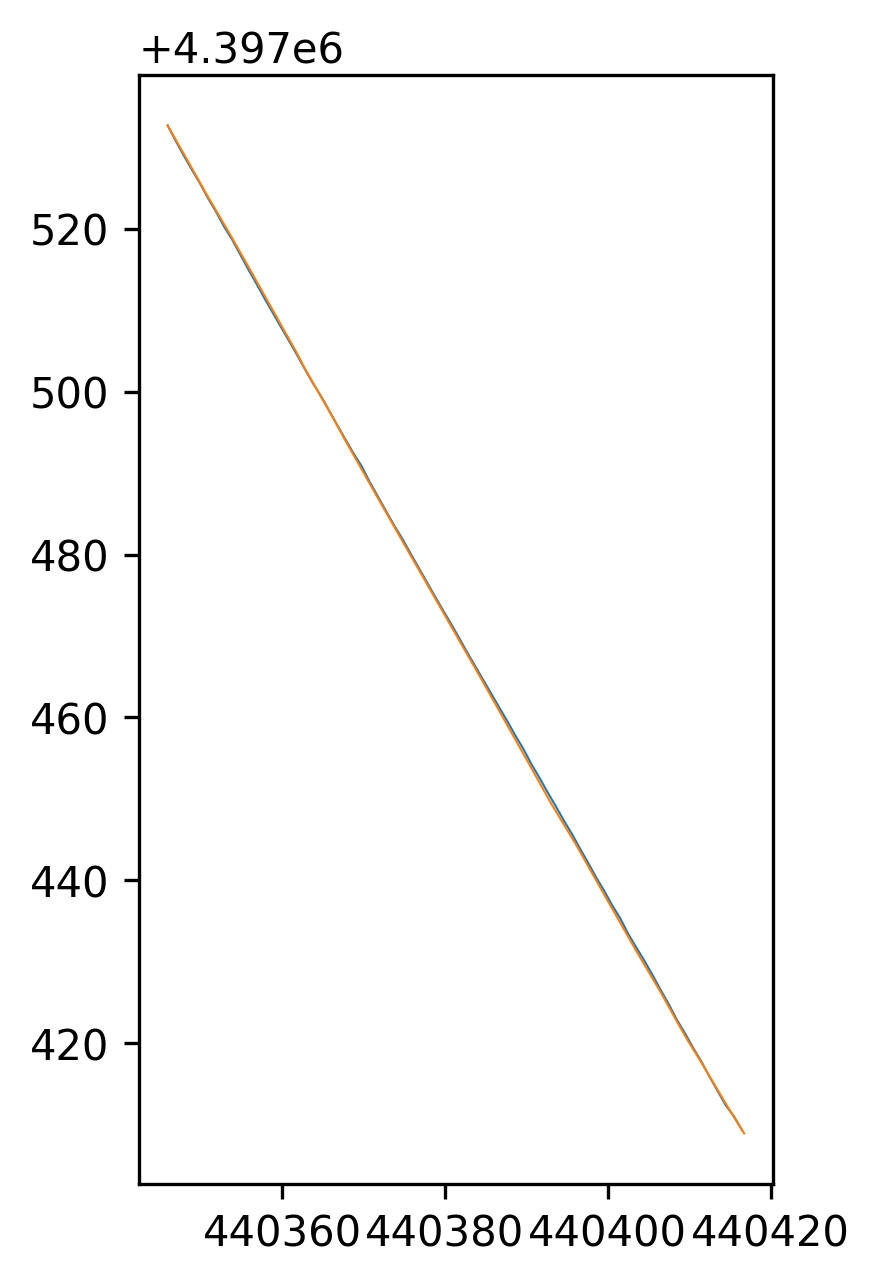

In [140]:
_, ax = plt.subplots(dpi=300)
single_simu_swath = all_simulated_lines.geometry.iloc[0]
single_real_swath = real_swath.geometry.iloc[0]
ax.plot(*single_simu_swath.xy, linewidth=0.5)
ax.plot(*single_real_swath.xy, linewidth=0.5)
ax.set_aspect('equal')
print(single_simu_swath.hausdorff_distance(single_real_swath))
print(list(single_simu_swath.coords)[:5])
print('------------------------------')
print(list(single_real_swath.coords)[:5])